In [ ]:
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, roc_curve, auc
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import shap
from keras.layers import Input, Dense, Flatten, \
    Concatenate, concatenate, Dropout, Lambda
from keras.models import Model, Sequential
from keras.layers.embeddings import Embedding
import keras
from livelossplot import PlotLossesKeras
import eli5
from eli5.sklearn import PermutationImportance
import scipy
from scipy.cluster import hierarchy as hc
from lime.lime_tabular import LimeTabularExplainer
import math
import xai
import alibi

params = {
          "ytick.color" : "w",
          "xtick.color" : "w",
          "text.color": "white",
          'figure.facecolor': "#384151",
          'legend.facecolor': "#384151",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
          'font.size': '20.0',
          'figure.figsize': [20, 7],
    }

plt.rcParams.update(params)


shap.initjs()


label_column = "loan"
csv_path = 'data/adult.data'
csv_columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country", "loan"]
input_columns = ["age", "workclass", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country"]
categorical_features = ["workclass", "education", "marital-status",
                       "occupation", "relationship", "ethnicity", "gender",
                       "native-country"]

def prepare_data(df):
    
    if "fnlwgt" in df: del df["fnlwgt"]
    
    tmp_df = df.copy()

    # normalize data (this is important for model convergence)
    dtypes = list(zip(tmp_df.dtypes.index, map(str, tmp_df.dtypes)))
    for k,dtype in dtypes:
        if dtype == "int64":
            tmp_df[k] = tmp_df[k].astype(np.float32)
            tmp_df[k] -= tmp_df[k].mean()
            tmp_df[k] /= tmp_df[k].std()

    cat_columns = tmp_df.select_dtypes(['object']).columns
    tmp_df[cat_columns] = tmp_df[cat_columns].astype('category')
    tmp_df[cat_columns] = tmp_df[cat_columns].apply(lambda x: x.cat.codes)
    tmp_df[cat_columns] = tmp_df[cat_columns].astype('int8')
    
    return tmp_df

def get_dataset_1():
    tmp_df = df.copy()
    tmp_df = tmp_df.groupby('loan') \
                .apply(lambda x: x.sample(100) if x["loan"].iloc[0] else x.sample(7_900)) \
                .reset_index(drop=True)
    
    X = tmp_df.drop(label_column, axis=1).copy()
    y = tmp_df[label_column].astype(int).values.copy()
    
    return tmp_df, df_display.copy()

def get_production_dataset():
    tmp_df = df.copy()
    tmp_df = tmp_df.groupby('loan') \
                .apply(lambda x: x.sample(50) if x["loan"].iloc[0] else x.sample(60)) \
                .reset_index(drop=True)
    
    X = tmp_df.drop(label_column, axis=1).copy()
    y = tmp_df[label_column].astype(int).values.copy()
    
    return X, y


def get_dataset_2():
    tmp_df = df.copy()
    tmp_df_display = df_display.copy()
#     tmp_df_display[label_column] = tmp_df_display[label_column].astype(int).values
    
    X = tmp_df.drop(label_column, axis=1).copy()
    y = tmp_df[label_column].astype(int).values.copy()
    
    X_display = tmp_df_display.drop(label_column, axis=1).copy()
    y_display = tmp_df_display[label_column].astype(int).values.copy()
    
    X_train, X_valid, y_train, y_valid = \
        train_test_split(X, y, test_size=0.2, random_state=7)

    return X, y, X_train, X_valid, y_train, y_valid, X_display, y_display, tmp_df, tmp_df_display
    
df_display = pd.read_csv(csv_path, names=csv_columns)
df_display[label_column] = df_display[label_column].apply(lambda x: ">50K" in x)
df = prepare_data(df_display)

def build_model(X):
    input_els = []
    encoded_els = []
    dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
    for k,dtype in dtypes:
        input_els.append(Input(shape=(1,)))
        if dtype == "int8":
            e = Flatten()(Embedding(df[k].max()+1, 1)(input_els[-1]))
        else:
            e = input_els[-1]
        encoded_els.append(e)
    encoded_els = concatenate(encoded_els)

    layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
    out = Dense(1, activation='sigmoid')(layer1)

    # train model
    model = Model(inputs=input_els, outputs=[out])
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
    return model

def f_in(X, m=None):
    """Preprocess input so it can be provided to a function"""
    if m:
        return [X.iloc[:m,i] for i in range(X.shape[1])]
    else:
        return [X.iloc[:,i] for i in range(X.shape[1])]

def f_out(probs):
    """Convert probabilities into classes"""
    return list((probs >= 0.5).astype(int).T[0])

def plot_roc(y, probs):
    
    fpr, tpr, _ = roc_curve(y, probs)

    roc_auc = auc(fpr, tpr)
    print(roc_auc)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (area = %0.2f)' % roc_auc)
    plt.legend(loc="lower right")
    plt.rcParams.update(params)
    plt.show()
    
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in list(np.logspace(0.6,4,dtype='int')):
        if m >= len(X_train): break
        model.fit(f_in(X_train,m), y_train[:m], epochs=50, batch_size=512, verbose=0)
        y_train_predict = model.predict(f_in(X_train,m))
        y_val_predict = model.predict(f_in(X_val))
        y_train_predict = f_out(y_train_predict)
        y_val_predict = f_out(y_val_predict)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    
def keras_score(self, X, y, **kwargs):
    """ Scorer class for eli5 library on feature importance"""
    input_test = [X[:,i] for i in range(X.shape[1])]
    loss = self.evaluate(input_test, y)
    if type(loss) is list:
        # The first one is the error, the rest are metrics
        return -loss[0]
    return -loss

class ModelWrapper():
    """ Keras model wrapper to override the predict function"""
    def __init__(self, model):
        self.model = model
    
    def predict(self, X, **kwargs):
        return self.model.predict([X.iloc[:,i] for i in range(X.shape[1])])

def plot_all_features(X, plot_numeric=True, hist=True, dropna=False):
    fig = plt.figure(figsize=(20,15))
    cols = 5
    rows = math.ceil(float(X.shape[1]) / cols)
    for i, column in enumerate(X.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if X.dtypes[column] == np.object:
            X[column].value_counts().plot(kind="bar", axes=ax)
        elif plot_numeric:
            if hist:
                X[column].hist(axes=ax)
                plt.xticks(rotation="vertical")
            else:
                if dropna:
                    X[column].dropna().plot()
                else:
                    X[column].plot()
                    
    plt.subplots_adjust(hspace=0.7, wspace=0.2)
    
def plot_dendogram(corr, X):
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method="average")
    fig = plt.figure(figsize=(16,5))
    dendrogram = hc.dendrogram(
        z, labels=X.columns, orientation="left", leaf_font_size=16)
    plt.show()
    
def shap_predict(X):
    values = model.predict([X[:,i] for i in range(X.shape[1])]).flatten()
    return values

def lime_predict_proba(X):
    values = model.predict([X[:,i] for i in range(X.shape[1])]).flatten()
    prob_pairs = np.array([1-values, values]).T
    return prob_pairs    


import alibi
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

alibi_data, alibi_labels, alibi_feature_names, alibi_category_map = alibi.datasets.adult()

def get_alibi_data():
    
    # define train and test set
    np.random.seed(0)
    data_perm = np.random.permutation(np.c_[alibi_data, alibi_labels])
    data = data_perm[:, :-1]
    labels = data_perm[:, -1]

    idx = 30000
    X_train, y_train = data[:idx, :], labels[:idx]
    X_test, y_test = data[idx + 1:, :], labels[idx + 1:]

    # feature transformation pipeline
    ordinal_features = [x for x in range(len(alibi_feature_names)) if x not in list(alibi_category_map.keys())]
    ordinal_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                          ('scaler', StandardScaler())])

    categorical_features = list(alibi_category_map.keys())
    categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                              ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(transformers=[('num', ordinal_transformer, ordinal_features),
                                                   ('cat', categorical_transformer, categorical_features)])


    np.random.seed(0)
    clf = RandomForestClassifier(n_estimators=50)

    alibi_loan_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('clf', clf)])

    alibi_loan_model.fit(X_train, y_train)
    
    return X_train, X_test, y_train, y_test, \
        alibi_category_map, alibi_feature_names, alibi_loan_model

X_train_alibi, X_test_alibi, y_train_alibi, y_test_alibi, \
    category_map_alibi, feature_names_alibi, loan_model_alibi = get_alibi_data()


# A practical guide towards explainability
# and bias evaluation in machine learning

<br>
<br>
<br>
<br>
<br>

<br>

<br>

<br>
<br>

<h2>Alejandro Saucedo</h2>
<br>
Chief Scientist, The Institute for Ethical AI & Machine Learning
<br>
Director of ML Engineering, Seldon Technologies

<br>

<br><br><br>

<hr>


# Today

<br>
<br>

## 1) Hands on example: Company "Hype-ML" automating loan approval process 

<br>
<br>

## 2) Terminology + why it's not about "just removing bias"

<br>
<br>

## 3) Data Analysis

<br>
<br>

## 4) Model Evaluation


<br>
<br>

## 4) Production Monitoring

<br>

<br><br><br>

<hr>

# Hype-ML - A NEW Project has come in!

<br>

* Insurance company has a process where domain expert approves/rejects loan applications

<br>

* They receive over 1m applications and want to automate the process

<br>

# Business wants it NOW!

<br>

* They heard their competitor is using "Machine Learning" and business says we need to use that



<br><br><br>

<hr>

# The team had a look at how this worked

<br>

<img src="images/mlall.png" style="width:70vw">



<br><br><br>

<hr>

# The team asked for DATA

<br>
<br>

## Business gave them an excel sheet with 25 rows

<br>
<br>

The team pushed back, and after a while they finally got a dataset with ~8000 rows




<br><br><br>

<hr>

<br><br><br>


# And so it begun...

<br>

<img src="images/copypasta.jpg" style="height:50vh">

<br>
<br>

## The Hype-ML journey towards greatness...

<br><br><br>

<hr>

<br><br><br>

In [157]:
df_data, df_display = get_dataset_1()

df_display.head()


,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country,loan
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,False
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,False
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,False
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,False
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,False


In [158]:
X = df_data.drop(label_column, axis=1).copy()
y = df_data[label_column].astype(int).values.copy()

X_train, X_valid, y_train, y_valid = \
        train_test_split(X, y, test_size=0.2, random_state=7)

print("Training size:", y_train.shape, "Testing size: ", y_valid.shape)

Training size: (6400,) Testing size:  (1600,)



<img src="images/train-test.png" style="width:70vw">

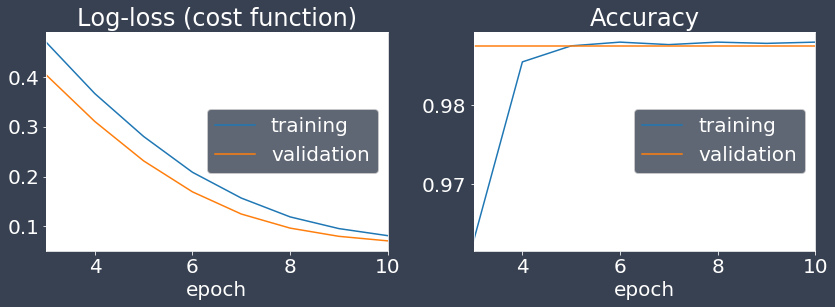

Log-loss (cost function):
training   (min:    0.081, max:    0.728, cur:    0.081)
validation (min:    0.071, max:    0.642, cur:    0.071)

Accuracy:
training   (min:    0.408, max:    0.988, cur:    0.988)
validation (min:    0.772, max:    0.988, cur:    0.988)


In [159]:
# 1 layer, 100 neurons model, with softmax (0-1 probabilities)
model = build_model(X)

model.fit(f_in(X_train), y_train, epochs=10,
    batch_size=512, shuffle=True, validation_data=(f_in(X_valid), y_valid),
    callbacks=[PlotLossesKeras()], verbose=0, validation_split=0.05,)

In [160]:
score = model.evaluate(f_in(X_valid), y_valid, verbose=1)
print("Error %.4f: " % score[0])
print("Accuracy %.4f: " % (score[1]*100))

1600/1600 [==============================] - 0s 41us/step
Error 0.0707: 
Accuracy 98.7500: 


# Accuracy is ~98%!

<br>
<br>
<br>
<br>

### What a better result on a Friday evening!

<br>
<br>
<br>

# Time for PROD?


<br><br><br>

<hr>

<br><br><br>


# We push to PROD!

<br>
<br>
<br>
<br>

### A few weeks go by...

<br>


<br><br><br>

<hr>

<br><br><br>


# BUZZFEED NEWS: HYPE-ML DEPLOYS RACIST SEXIST AI!!!!

<br>

<img src="images/layer.jpg" style="height: 50vh">


<br>


# ...but... but we followed the instructions in the internet!


<br><br><br>

<hr>

<br><br><br>


# Time to diagnose!

<br>
<br>

## We ask business to gather the 110 applications in production...

<br>
<br>

## ...and label it to understand what went wrong


<br><br><br>

<hr>

<br><br><br>

In [161]:
X_prod, y_prod = get_production_dataset()

print(X_prod.shape)
X_prod.head()

(110, 13)


,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country
0,-1.288936,4,11,-0.420053,4,12,3,4,0,-0.145918,-0.216656,-0.440371,39
1,-1.288936,4,15,-0.031359,4,8,3,4,0,-0.145918,-0.216656,-0.035429,39
2,-1.288936,4,15,-0.031359,4,12,3,4,0,-0.145918,-0.216656,1.179399,39
3,1.643522,4,15,-0.031359,2,10,0,4,1,-0.145918,-0.216656,0.126548,39
4,-1.288936,4,15,-0.031359,4,8,1,4,0,-0.145918,-0.216656,-0.035429,39


In [162]:
score = model.evaluate(f_in(X_prod), y_prod, verbose=1)
probabilities = model.predict(f_in(X_prod))
pred = f_out(probabilities)
print("Accuracy %.4f: " % (score[1]*100))

110/110 [==============================] - 0s 73us/step
Accuracy 54.5455: 


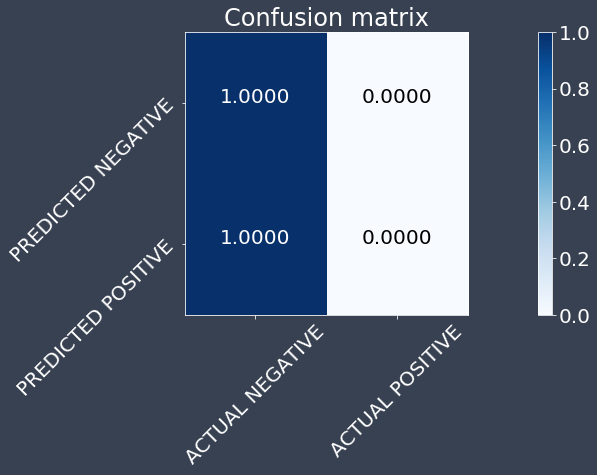

In [163]:
xai.confusion_matrix_plot(y_prod, pred)

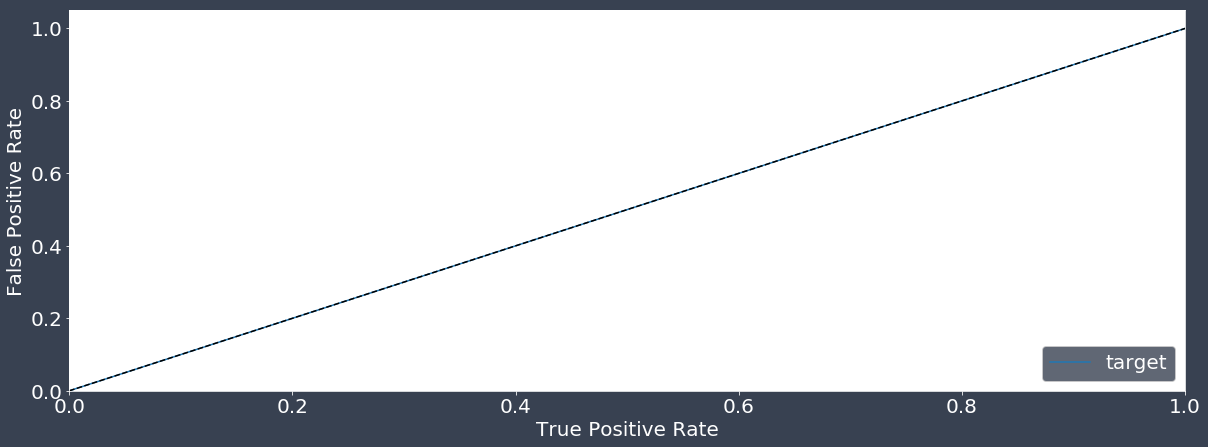

([array([0., 1.]), array([0., 1.])], [array([0., 1.]), array([0., 1.])])

In [164]:
xai.roc_plot(y_prod, pred) 

[Text(0, 0, 'Rejected'), Text(0, 0, 'Approved')]

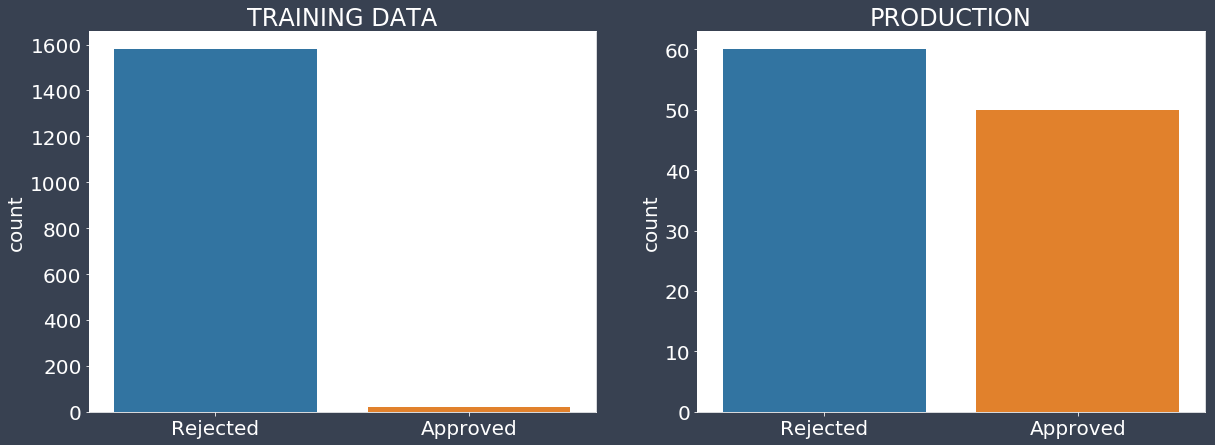

In [165]:
fig, ax = plt.subplots(1,2)
a = sn.countplot(y_valid, ax=ax[0]); a.set_title("TRAINING DATA"); a.set_xticklabels(["Rejected", "Approved"])
a = sn.countplot(y_prod, ax=ax[1]); a.set_title("PRODUCTION"); a.set_xticklabels(["Rejected", "Approved"])

# Undesired bias and explainability

<br>

* Has become popular due to several high profile incidents:

    * Amazon's "sexist" recruitment tool
    * Microsoft's "racist" chatbot
    * Negative discrimination in automated sentencing
    * Black box models with complex patterns that can't be interpretable

<br>
<br>

## Organisations cannot take on unknown risks

<br><br><br>

<hr>

<br><br><br>

# This challenge goes beyond the algorithms

<br>

### A large ethical decision should not just fall on the shoulders of a single data scientist

<br>

<img src="images/chart.png" style="height:30vw;margin-left: 10vw; float: left; background-color: transparent">
<img src="images/chart-more.png" style="height:30vw; margin-left: 10vw; float: left;  background-color: transparent">

<br><br><br>

<hr>

<br><br><br>

# The answer is not just about "removing bias"

<br>
<br>

* Any non trivial decision (i.e. more than 1 option) holds a bias, without exceptions.
* It's impossible to "just remove bias", as the whole purpose of ML is to discriminate towards the right answer
* Societal bias carries an inherent bias - what may be "racist" for one person, may not be for another group or geography

<br>
<br>

## Let's see what "undesired bias" looks like

<br><br><br>

<hr>

<br><br><br>

# Split into two conceptual pieces

<br>
<br>

## 1) Statistical bias 

##### The "error" between from where you are to where you CAN be.

<br>
<br>

## 2) A-priori bias 

##### The "error" between where you CAN be to where you SHOULD be.

# Statistical bias: Errors in project decisions

<br>

## Sub-optimal choices of accuracy metrics / cost functions

<br>

## Sub-optimal machine learning models chosen for the task 

<br>

## Lack of infrastructure or metrics required to monitor model performance in production

<br>

## Lack of human-in-the-loop where necessary

<br>

## Not using resources at disposal (e.g. domain experts, tools, etc).

<br><br><br>

<hr>

<br><br><br>

# A-priori bias: Bias introduced through societal or scope diversions

<br>

## Sub-optimal business objectives

<br>

## Lack of understanding of the project 

<br>

## Incomplete resources (data, time, domain experts, etc)

<br>

## Incorrectly labelled data (accident vs otherwise)

<br>

## Lack of relevant skillset

<br>

## Societal shifts in perception

<br><br><br>

<hr>

<br><br><br>

# Explainability is key

<br>
<br>

* To identify and evaluate undersired biases

<br>

* For definitions of regulatory demands (GDPR)

<br>

* For compliance of processes

<br>

* To identify and reduce risks (FP vs FN)

# Key Point: Explainability !== Interpretability

<br>

*  Having a model that can be interpreted doesn't mean it can be explained

<br>

* Explainability requires us to go beyond the algorithms

<br>

* Undesired bias cannot be tackled without explainability


<br><br><br>

<hr>

<br><br><br>

# Remember our workflow? Let's add three new steps:

<br>

<img src="images/mlall.png" style="width=100vw">

# Augmenting the data science workflow

<br>

<img src="images/gml.png" style="width=100vw">


<br><br><br>

<hr>

<br><br><br>

# The Explainability Tradeoff

<br>

## Introducing fail-safe mechanisms, removing features, and using simpler models may have an impact on accuracy

<br>

## Not all usecases demand the same level of scrutiny

<br>

## The ones that are more critical do require a more strict process

<br>

## Similar to enterprise software, the overhead to offer accountability and governance is introduced


<br><br><br>

<hr>

<br><br><br>


# 1) Data Analysis

<br><br><br>

<hr>

<br><br><br>

#### Points to cover

1.1) Data imbalances

1.2) Upsampling / downsampling

1.3) Correlations

1.4) Train / test set

1.5) Further techniques

# XAI - eXplainable AI 

<br>

## A set of tools to explain machine learning data

<br>

<img src="images/xai.jpg" style="width=100vw">

<br>

## https://github.com/EthicalML/XAI


<br><br><br>

<hr>

## Let's get the new training dataset

In [166]:
X, y, X_train, X_valid, y_train, y_valid, X_display, y_display, df, df_display \
    = get_dataset_2()
df_display.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country,loan
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,False
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,False
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,False
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,False
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,False


## 1.1) Data imbalances
#### We can visualise the imbalances by looking at the number of examples for each class

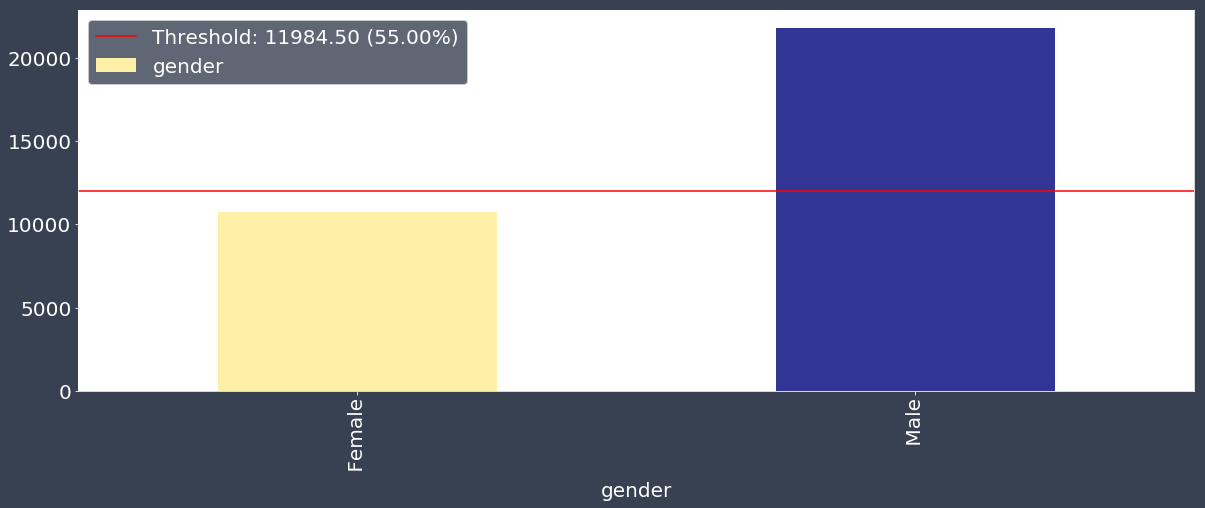

In [167]:
im = xai.imbalance_plot(df_display, "gender", threshold=0.55, categorical_cols=["gender"])

#### We can evaluate imbalances by the product of multiple categories

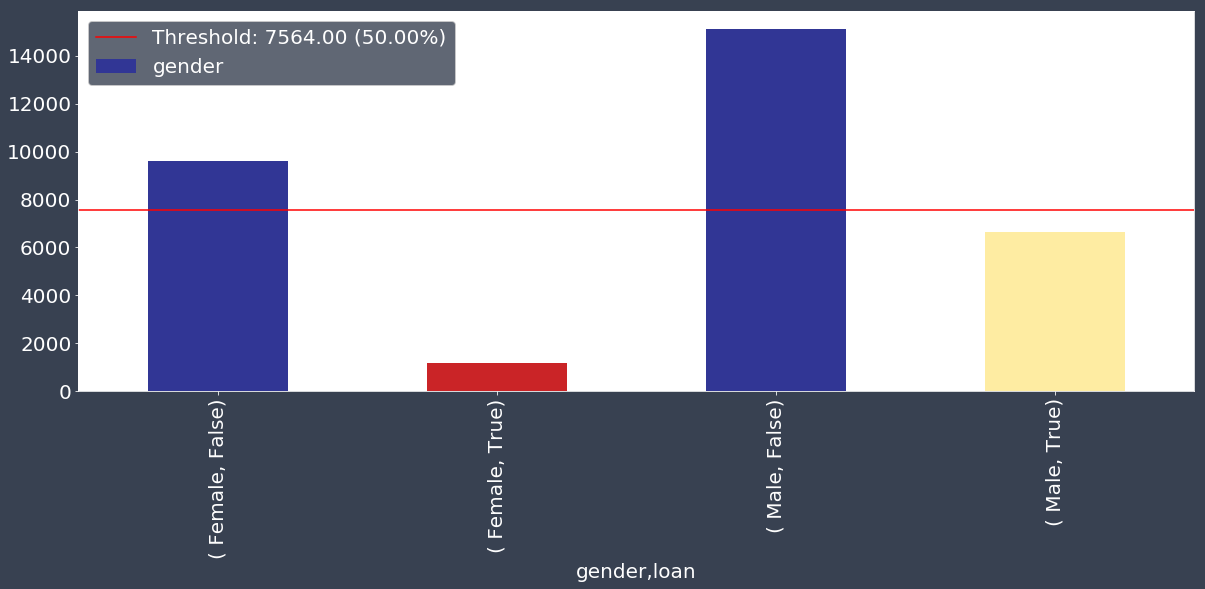

In [168]:
im = xai.imbalance_plot(df_display, "gender", "loan" , categorical_cols=["loan", "gender"])

#### For numeric datasets we can break it down in bins

       'relationship', 'ethnicity', 'gender', 'native-country', 'loan'],
      dtype='object'). If you see an error these are not correct, please provide them as a string array as: categorical_cols=['col1', 'col2', ...]


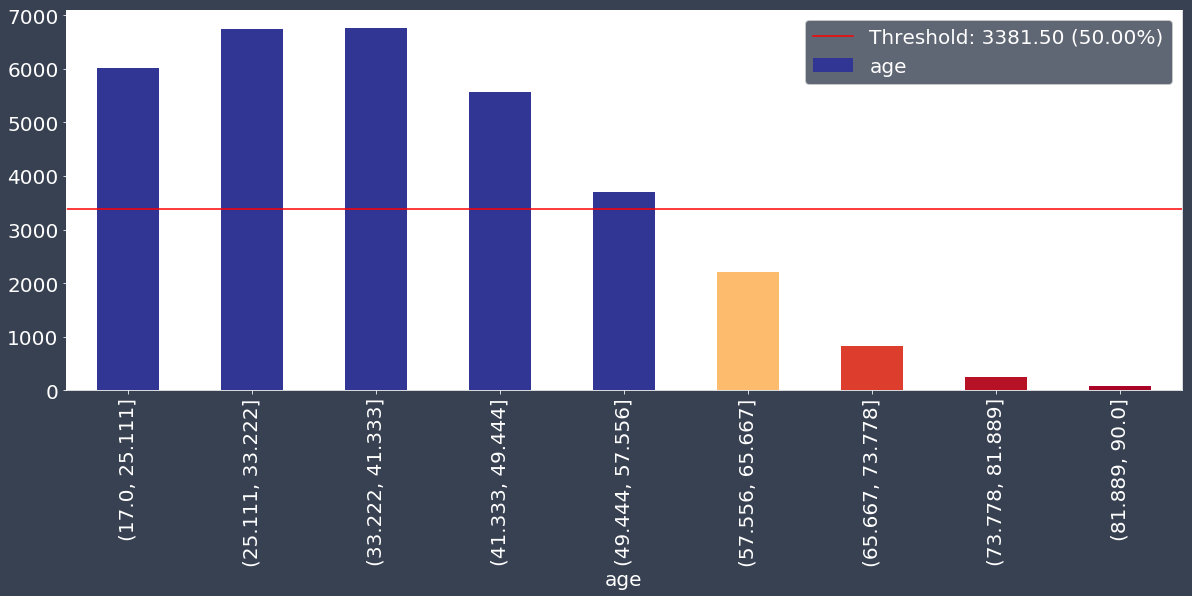

In [169]:
im = xai.imbalance_plot(df_display, "age" , bins=10)

## 1.2) Upsampling / Downsampling

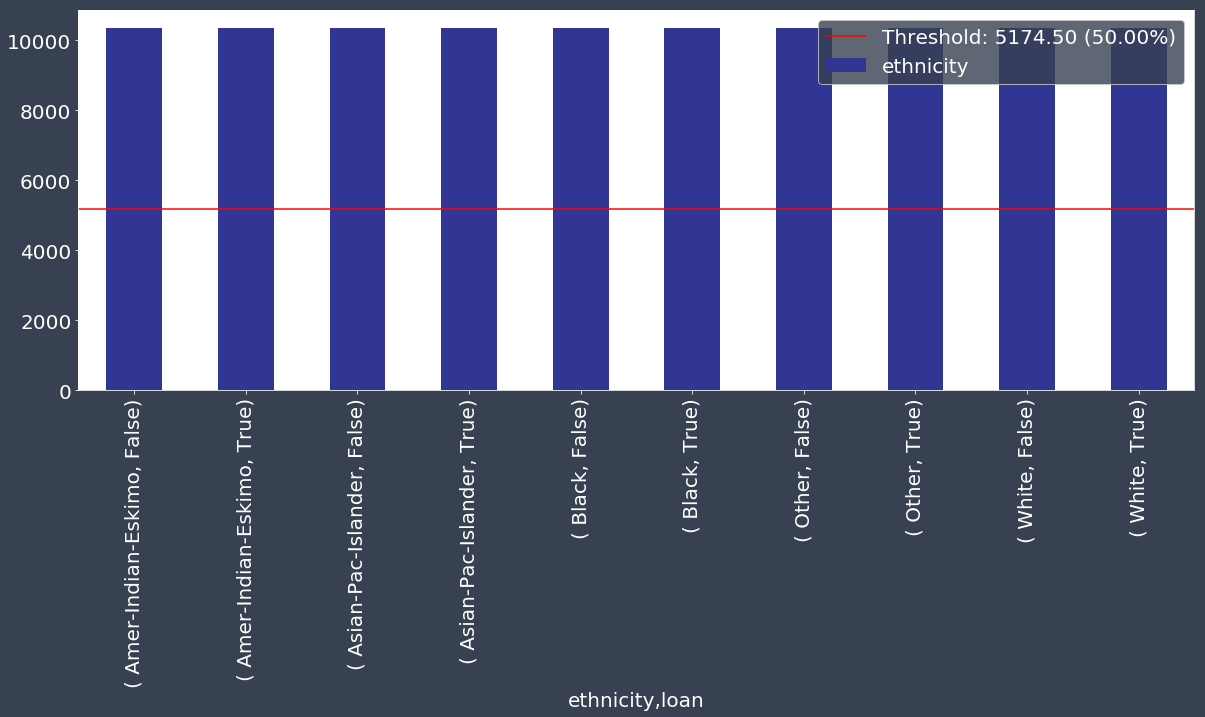

In [171]:
im = xai.balance(df_display, "ethnicity", "loan", categorical_cols=["ethnicity", "loan"],
                upsample=0.5, downsample=0.5, bins=5)

## 1.3 Correlations hidden in data
#### We can identify potential correlations across variables through a dendogram visualiation

/home/alejandro/miniconda3/envs/reddit-classification/lib/python3.7/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


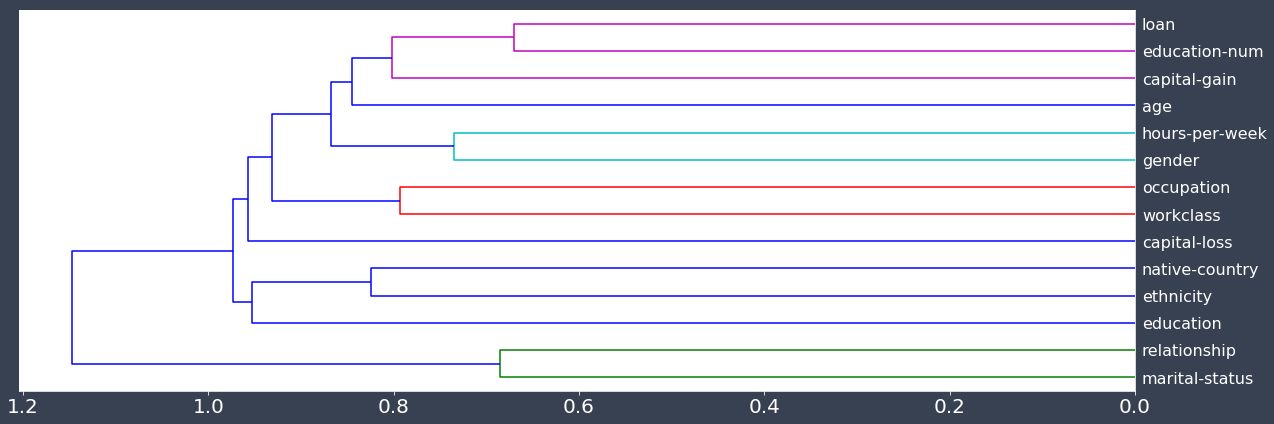

In [172]:
corr = xai.correlations(df_display, include_categorical=True)

## 1.4) Balanced train/testing sets

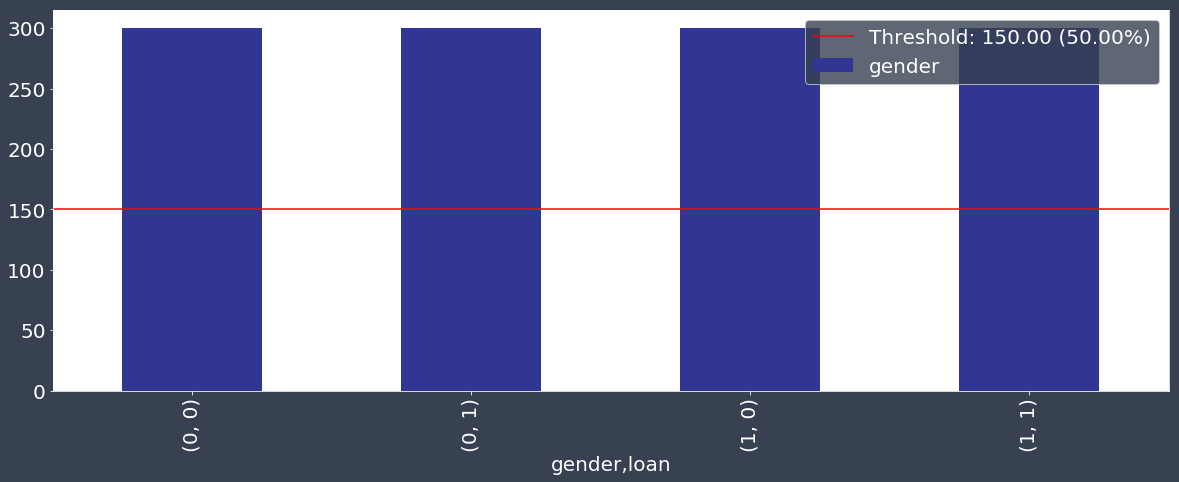

In [173]:
X_train_balanced, y_train_balanced, X_valid_balanced, y_valid_balanced, train_idx, test_idx = \
    xai.balanced_train_test_split(
            X, y, "gender", 
            min_per_group=300,
            max_per_group=300,
            categorical_cols=["gender", "loan"])

X_valid_balanced["loan"] = y_valid_balanced
im = xai.imbalance_plot(X_valid_balanced, "gender", "loan", categorical_cols=["gender", "loan"])

## 1.5 Shoutout to other tools and techniques
https://github.com/EthicalML/awesome-production-machine-learning#industrial-strength-visualisation-libraries
![](images/dataviz.jpg)

# 2) Model evaluation

<br><br><br>

<hr>

<br><br><br>

#### Points to cover

2.1) Standard model evaluation metrics

2.2) Global model explanation techniques

2.3) Black box local model explanation techniques

2.4) Other libraries available

# Alibi - Black Box Model Explanations

<br>

## A set of proven scientific techniques to explain ML models as black boxes

<br>

<img src="images/alibi-repo-new.jpg" style="width=100vw">

<br>

## https://github.com/SeldonIO/Alibi


<br><br><br>

<hr>

# Model Evaluation Metrics: White / Black Box

![](images/whiteblackbox.jpg)

# Model Evaluation Metrics: Global vs Local

![](images/globallocal.jpg)

## 2.1) Standard model evaluation metrics

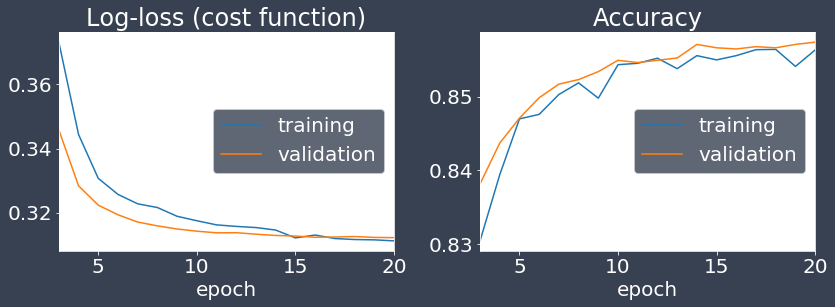

Log-loss (cost function):
training   (min:    0.311, max:    0.581, cur:    0.311)
validation (min:    0.312, max:    0.464, cur:    0.312)

Accuracy:
training   (min:    0.724, max:    0.856, cur:    0.856)
validation (min:    0.808, max:    0.857, cur:    0.857)


In [174]:
# Let's start by building our model with our newly balanced dataset
model = build_model(X)
model.fit(f_in(X_train), y_train, epochs=20, batch_size=512, shuffle=True, validation_data=(f_in(X_valid), y_valid), callbacks=[PlotLossesKeras()], verbose=0, validation_split=0.05,)
probabilities = model.predict(f_in(X_valid))
pred = f_out(probabilities)

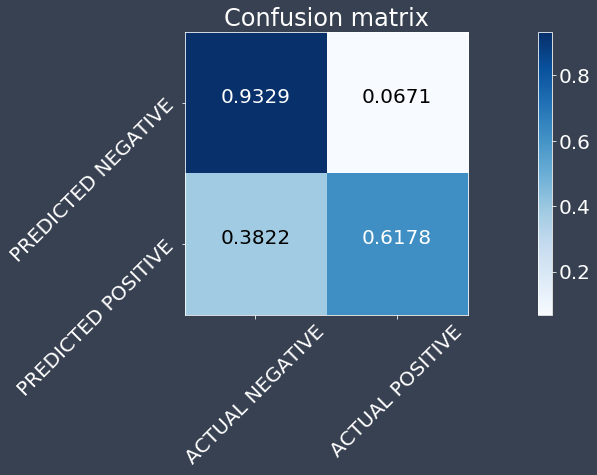

In [175]:
xai.confusion_matrix_plot(y_valid, pred)

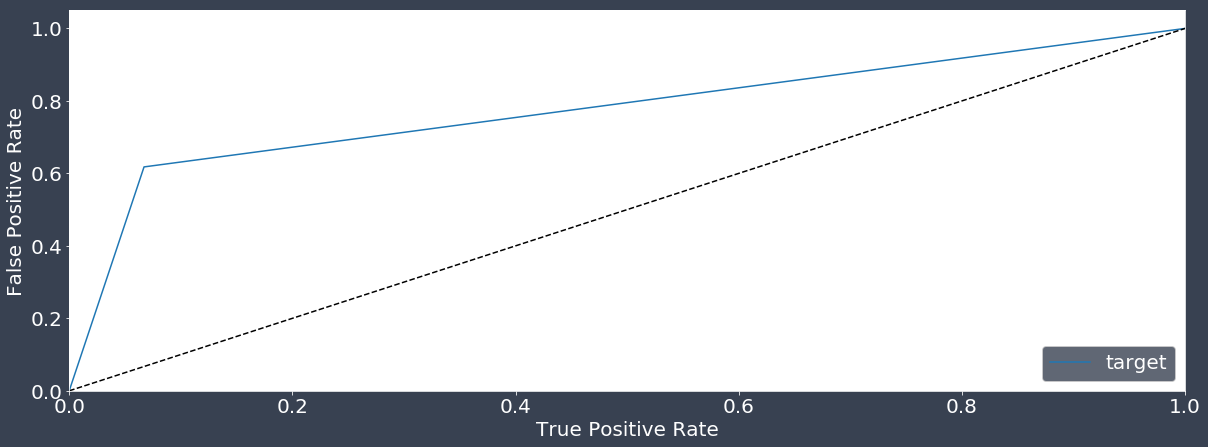

In [176]:
im = xai.roc_plot(y_valid, pred)

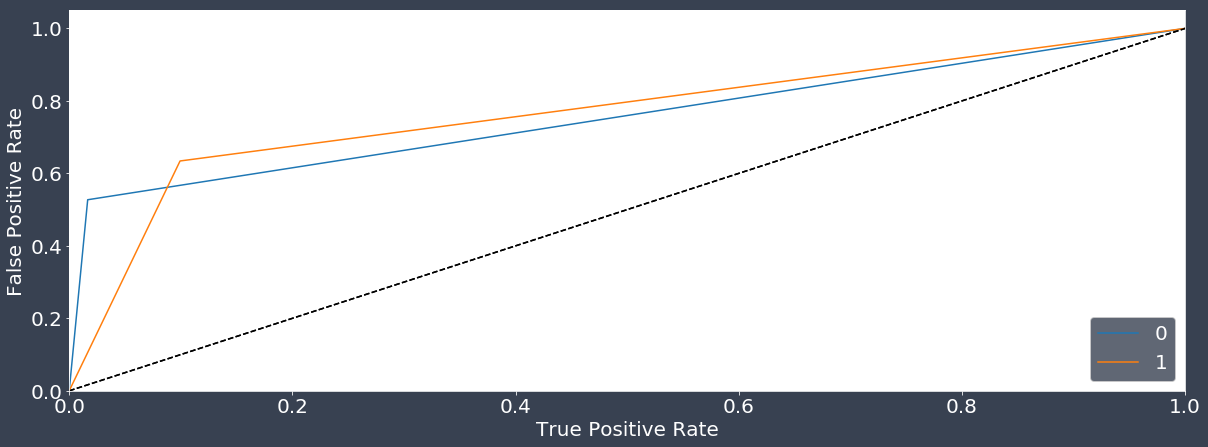

In [177]:
im = xai.roc_plot(y_valid, pred, df=X_valid, cross_cols=["gender"], categorical_cols=["gender"])

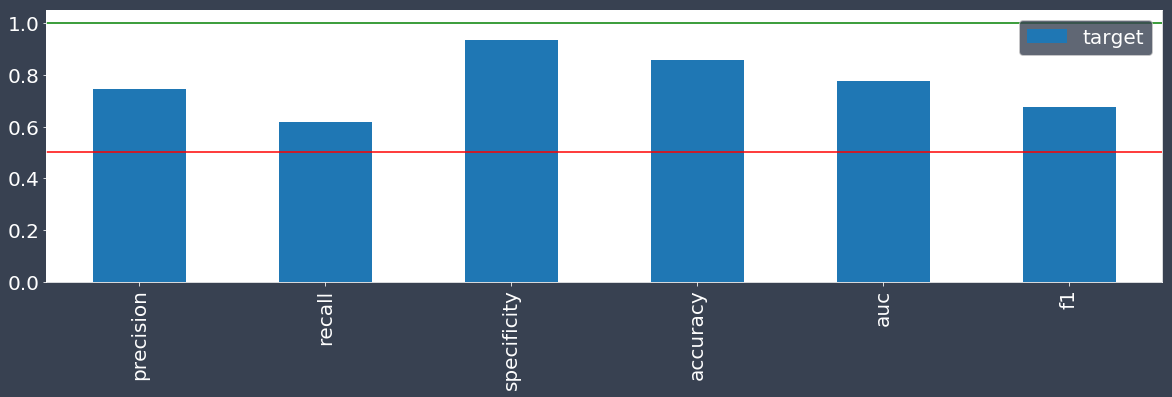

In [178]:
im = xai.metrics_plot(y_valid, pred)

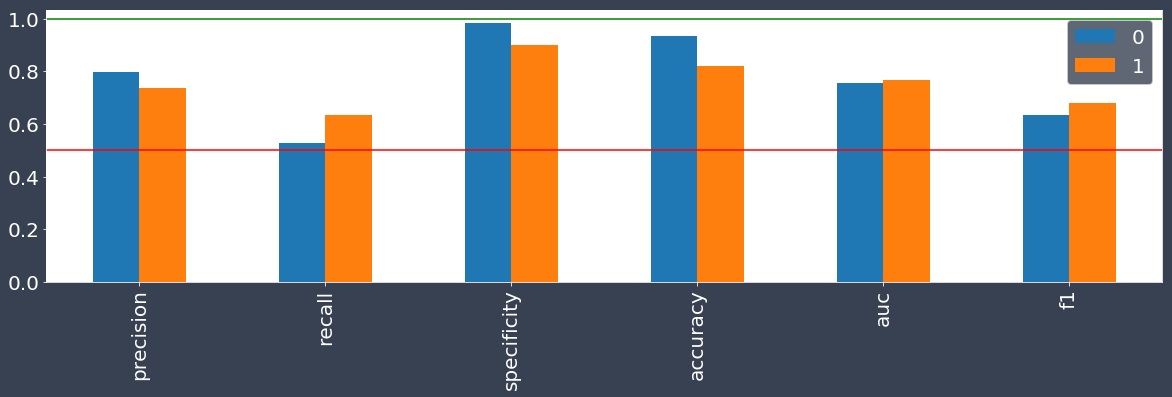

In [179]:
im = xai.metrics_plot(y_valid, pred, df=X_valid, cross_cols=["gender"], categorical_cols="gender")

# 2.2) Global black box model evalutaion metrics

/home/alejandro/miniconda3/envs/reddit-classification/lib/python3.7/site-packages/xai/__init__.py:1127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  x[c] = tmp


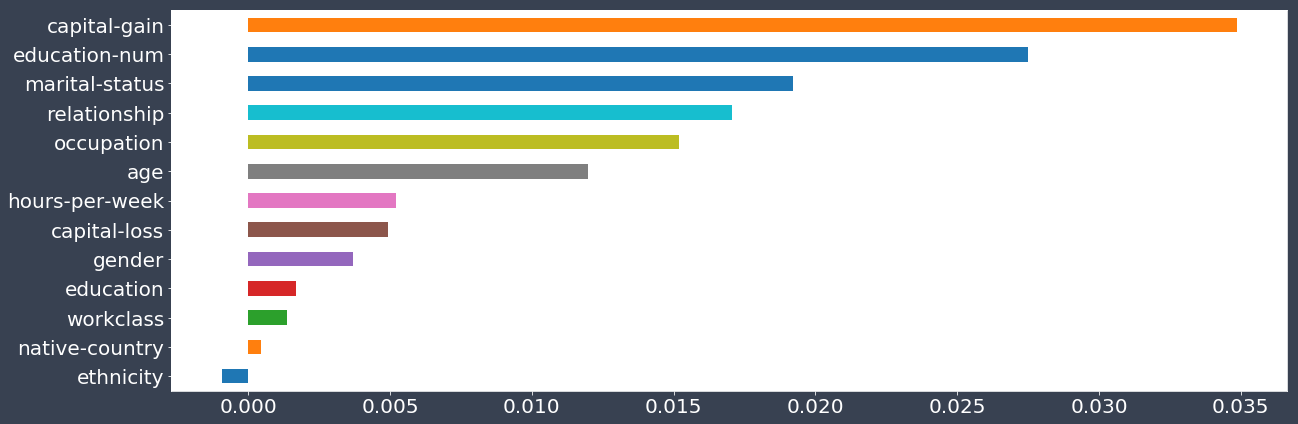

In [180]:
imp = xai.feature_importance(X_valid, y_valid, lambda x, y: model.evaluate(f_in(x), y, verbose=0)[1], repeat=1)

# 2.3) Local black box model evaluation metrics
### Overview of methods

![](images/alibi-table.jpg)

# Anchors 

<br>

#### Consists of if-then rules, called the anchors, which sufficiently guarantee the explanation locally and try to maximize the area for which the explanation holds. (ArXiv: Anchors: High-Precision Model-Agnostic Explanations)

<br>

<div style="float: left; width: 50%">
<img src="images/textanchor.jpg">
</div>

<div style="float: left; width: 50%">
<img src="images/anchorimage.jpg">
</div>

In [181]:
from alibi.explainers import AnchorTabular

explainer = AnchorTabular(
    loan_model_alibi.predict, 
    feature_names_alibi, 
    categorical_names=category_map_alibi)

explainer.fit(
    X_train_alibi, 
    disc_perc=[25, 50, 75])

print("Explainer built")

Explainer built


In [183]:
X_test_alibi[:1]

array([[52,  4,  0,  2,  8,  4,  2,  0,  0,  0, 60,  9]])

In [184]:
explanation = explainer.explain(X_test_alibi[:1], threshold=0.95)

print('Anchor: %s' % (' AND '.join(explanation['names'])))
print('Precision: %.2f' % explanation['precision'])
print('Coverage: %.2f' % explanation['coverage'])

Anchor: Marital Status = Separated AND Sex = Female AND Capital Gain <= 0.00
Precision: 0.97
Coverage: 0.10


# Counterfactual Explanations

### The counterfactual explanation of an outcome or a situation Y takes the form “If X had not occured, Y would not have occured” 

![](images/counterfactuals7.jpg)

## 1.5 Shoutout to other tools and techniques
https://github.com/EthicalML/awesome-production-machine-learning#explaining-black-box-models-and-datasets
![](images/modevallibs.jpg)

# 3) Production Monitoring

<br><br><br>

<hr>

<br><br><br>

#### Key points to cover

<br>

1) Design patterns for explainers

<br>

2) Live demo of explainers

<br>

3) Leveraging humans for explainers

# Seldon Core - Production ML in K8s

<br>

## A language agnostic ML serving & monitoring framework in Kubernetes

<br>

<img src="images/seldon-core-repo.jpg" style="width=100vw">

<br>

## https://github.com/SeldonIO/seldon-core


<br><br><br>

<hr>

# 3.1) Design patterns for explainers

![](images/deployment-overview.jpg)

#### Setup Seldon in your kubernetes cluster

In [ ]:
%%bash
kubectl create clusterrolebinding kube-system-cluster-admin --clusterrole=cluster-admin --serviceaccount=kube-system:default
helm init
kubectl rollout status deploy/tiller-deploy -n kube-system
helm install seldon-core-operator --name seldon-core-operator --repo https://storage.googleapis.com/seldon-charts
helm install seldon-core-analytics --name seldon-core-analytics --repo https://storage.googleapis.com/seldon-charts
helm install stable/ambassador --name ambassador

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# feature transformation pipeline
ordinal_features = [x for x in range(len(alibi_feature_names)) if x not in list(alibi_category_map.keys())]
ordinal_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())])

categorical_features = list(alibi_category_map.keys())
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', ordinal_transformer, ordinal_features),
                                               ('cat', categorical_transformer, categorical_features)])

In [ ]:
preprocessor.fit(alibi_data)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

np.random.seed(0)
clf = RandomForestClassifier(n_estimators=50)
clf.fit(preprocessor.transform(X_train_alibi), y_train_alibi)

In [ ]:
!mkdir -p pipeline/pipeline_steps/loanclassifier/

#### Save the model artefacts so we can deploy them

In [185]:
import dill

with open("pipeline/pipeline_steps/loanclassifier/preprocessor.dill", "wb") as prep_f:
    dill.dump(preprocessor, prep_f)
    
with open("pipeline/pipeline_steps/loanclassifier/model.dill", "wb") as model_f:
    dill.dump(clf, model_f)

#### Build a Model wrapper that uses the trained models through a predict function

In [ ]:
%%writefile pipeline/pipeline_steps/loanclassifier/Model.py
import dill

class Model:
    def __init__(self, *args, **kwargs):
        
        with open("preprocessor.dill", "rb") as prep_f:
            self.preprocessor = dill.load(prep_f)
        with open("model.dill", "rb") as model_f:
            self.clf = dill.load(model_f)
        
    def predict(self, X, feature_names=[]):
        X_prep = self.preprocessor.transform(X)
        proba = self.clf.predict_proba(X_prep)
        return proba

#### Add the dependencies for the wrapper to work

In [ ]:
%%writefile pipeline/pipeline_steps/loanclassifier/requirements.txt
scikit-learn==0.20.1
dill==0.2.9
scikit-image==0.15.0
scikit-learn==0.20.1
scipy==1.1.0
numpy==1.15.4

In [ ]:
!mkdir pipeline/pipeline_steps/loanclassifier/.s2i

In [ ]:
%%writefile pipeline/pipeline_steps/loanclassifier/.s2i/environment
MODEL_NAME=Model
API_TYPE=REST
SERVICE_TYPE=MODEL
PERSISTENCE=0

#### Use the source2image command to containerize code

In [ ]:
!s2i build pipeline/pipeline_steps/loanclassifier seldonio/seldon-core-s2i-python3:0.8 loanclassifier:0.1

#### Define the graph of your pipeline with individual models

In [ ]:
%%writefile pipeline/pipeline_steps/loanclassifier/loanclassifiermodel.yaml
apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  labels:
    app: seldon
  name: loanclassifier
spec:
  name: loanclassifier
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: loanclassifier:0.1
          name: model
    graph:
      children: []
      name: model
      type: MODEL
      endpoint:
        type: REST
    name: loanclassifier
    replicas: 1

#### Deploy your model!

In [ ]:
!kubectl apply -f pipeline/pipeline_steps/loanclassifier/loanclassifiermodel.yaml

#### Now we can send data through the REST API

In [186]:
X_test_alibi[:1]

array([[52,  4,  0,  2,  8,  4,  2,  0,  0,  0, 60,  9]])

In [187]:
%%bash
curl -X POST -H 'Content-Type: application/json' \
    -d "{'data': {'names': ['text'], 'ndarray': [[52,  4,  0,  2,  8,  4,  2,  0,  0,  0, 60,  9]]}}" \
    http://localhost:80/seldon/default/loanclassifier/api/v0.1/predictions

{
  "meta": {
    "puid": "96cmdkc4k1c6oassvpnpasqbgf",
    "tags": {
    },
    "routing": {
    },
    "requestPath": {
      "model": "loanclassifier:0.1"
    },
    "metrics": []
  },
  "data": {
    "names": ["t:0", "t:1"],
    "ndarray": [[0.86, 0.14]]
  }
}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   356  100   264  100    92  11000   3833 --:--:-- --:--:-- --:--:-- 15478


#### We can also reach it with the Python Client

In [188]:
from seldon_core.seldon_client import SeldonClient

batch = X_test_alibi[:1]

sc = SeldonClient(
    gateway="ambassador", 
    gateway_endpoint="localhost:80",
    deployment_name="loanclassifier",
    payload_type="ndarray",
    namespace="default",
    transport="rest")

client_prediction = sc.predict(data=batch)

print(client_prediction.response)

meta {
  puid: "hv4dnmr8m3ckgrhtnc48rs7mjg"
  requestPath {
    key: "model"
    value: "loanclassifier:0.1"
  }
}
data {
  names: "t:0"
  names: "t:1"
  ndarray {
    values {
      list_value {
        values {
          number_value: 0.86
        }
        values {
          number_value: 0.14
        }
      }
    }
  }
}



#### Now we can create an explainer for our model

In [189]:
from alibi.explainers import AnchorTabular

predict_fn = lambda x: clf.predict(preprocessor.transform(x))
explainer = AnchorTabular(predict_fn, alibi_feature_names, categorical_names=alibi_category_map)
explainer.fit(X_train_alibi, disc_perc=[25, 50, 75])

explanation = explainer.explain(X_test_alibi[0], threshold=0.95)

print('Anchor: %s' % (' AND '.join(explanation['names'])))
print('Precision: %.2f' % explanation['precision'])
print('Coverage: %.2f' % explanation['coverage'])

Anchor: Marital Status = Separated AND Sex = Female AND Capital Gain <= 0.00
Precision: 0.97
Coverage: 0.10


In [ ]:

def predict_remote_fn(X):
    from seldon_core.seldon_client import SeldonClient
    from seldon_core.utils import get_data_from_proto
    
    kwargs = {
        "gateway": "ambassador", 
        "deployment_name": "loanclassifier",
        "payload_type": "ndarray",
        "namespace": "default",
        "transport": "rest"
    }
    
    try:
        kwargs["gateway_endpoint"] = "localhost:80"
        sc = SeldonClient(**kwargs)
        prediction = sc.predict(data=X)
    except:
        # If we are inside the container, we need to reach the ambassador service directly
        kwargs["gateway_endpoint"] = "ambassador:80"
        sc = SeldonClient(**kwargs)
        prediction = sc.predict(data=X)
    
    y = get_data_from_proto(prediction.response)
    return y


#### But now we can use the remote model we have in production

In [ ]:
# Summary of the predict_remote_fn
def predict_remote_fn(X):
    ....
    sc = SeldonClient(...)
    prediction = sc.predict(data=X)
    y = get_data_from_proto(prediction.response)
    return y

#### And train our explainer to use the remote function

In [190]:
from seldon_core.utils import get_data_from_proto

explainer = AnchorTabular(predict_remote_fn, alibi_feature_names, categorical_names=alibi_category_map)
explainer.fit(X_train_alibi, disc_perc=[25, 50, 75])

explanation = explainer.explain(X_test_alibi[idx], threshold=0.95)

print('Anchor: %s' % (' AND '.join(explanation['names'])))
print('Precision: %.2f' % explanation['precision'])
print('Coverage: %.2f' % explanation['coverage'])

Anchor: Marital Status = Separated AND Sex = Female
Precision: 0.97
Coverage: 0.11


#### To containerise our explainer, save the trained binary


In [ ]:
import dill

with open("pipeline/pipeline_steps/loanclassifier-explainer/explainer.dill", "wb") as x_f:
    dill.dump(explainer, x_f)

#### Expose it through a wrapper

In [ ]:
%%writefile pipeline/pipeline_steps/loanclassifier-explainer/Explainer.py
import dill
import json
import numpy as np

class Explainer:
    def __init__(self, *args, **kwargs):
        
        with open("explainer.dill", "rb") as x_f:
            self.explainer = dill.load(x_f)
        
    def predict(self, X, feature_names=[]):
        print("Received: " + str(X))
        explanation = self.explainer.explain(X)
        print("Predicted: " + str(explanation))
        return json.dumps(explanation, cls=NumpyEncoder)

    
    
    
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (
        np.int_, np.intc, np.intp, np.int8, np.int16, np.int32, np.int64, np.uint8, np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

#### Add config files to build image with script

In [ ]:
!s2i build pipeline/pipeline_steps/loanclassifier-explainer seldonio/seldon-core-s2i-python3:0.8 loanclassifier-explainer:0.1

In [ ]:
!mkdir -p pipeline/pipeline_steps/loanclassifier-explainer

In [ ]:
%%writefile pipeline/pipeline_steps/loanclassifier-explainer/loanclassifiermodel-explainer.yaml
apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  labels:
    app: seldon
  name: loanclassifier-explainer
spec:
  name: loanclassifier-explainer
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: loanclassifier-explainer:0.1
          name: model-explainer
    graph:
      children: []
      name: model-explainer
      type: MODEL
      endpoint:
        type: REST
    name: loanclassifier-explainer
    replicas: 1

#### Deploy your remote explainer

In [ ]:
!kubectl apply -f pipeline/pipeline_steps/loanclassifier-explainer/loanclassifiermodel-explainer.yaml

#### Now we can request explanations throught the REST API

In [191]:
%%bash
curl -X POST -H 'Content-Type: application/json' \
    -d "{'data': {'names': ['text'], 'ndarray': [[52,  4,  0,  2,  8,  4,  2,  0,  0,  0, 60, 9]] }}" \
    http://localhost:80/seldon/default/loanclassifier-explainer/api/v0.1/predictions

{
  "meta": {
    "puid": "ohbll5bcpu9gg7jjj1unll4155",
    "tags": {
    },
    "routing": {
    },
    "requestPath": {
      "model-explainer": "loanclassifier-explainer:0.1"
    },
    "metrics": []
  },
  "strData": "{\"names\": [\"Marital Status = Separated\", \"Sex = Female\"], \"precision\": 0.9629629629629629, \"coverage\": 0.1078, \"raw\": {\"feature\": [3, 7], \"mean\": [0.9002808988764045, 0.9629629629629629], \"precision\": [0.9002808988764045, 0.9629629629629629], \"coverage\": [0.1821, 0.1078], \"examples\": [{\"covered\": [[46, 4, 4, 2, 2, 1, 4, 1, 0, 0, 45, 9], [24, 4, 1, 2, 6, 3, 2, 1, 0, 0, 40, 9], [39, 4, 4, 2, 4, 1, 4, 1, 4650, 0, 44, 9], [40, 4, 0, 2, 5, 4, 4, 0, 0, 0, 32, 9], [39, 4, 1, 2, 8, 0, 4, 1, 3103, 0, 50, 9], [45, 4, 1, 2, 6, 5, 4, 0, 0, 0, 42, 9], [41, 4, 1, 2, 5, 1, 4, 1, 0, 0, 40, 9], [40, 4, 4, 2, 2, 0, 4, 1, 0, 0, 40, 9], [58, 4, 3, 2, 2, 2, 4, 0, 0, 0, 45, 5], [23, 4, 1, 2, 5, 1, 4, 1, 0, 0, 50, 9]], \"covered_true\": [[33, 4, 4, 2, 2, 0, 4, 1, 0, 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3464  100  3372  100    92   3318     90  0:00:01  0:00:01 --:--:--  3409


### Now we have an explainer deployed!

![](images/deployment-overview.jpg)

# Visualise metrics and explanations 

![](images/deploy-expl.jpg)

# Leveraging Humans for Explanations



![](images/smile1.jpg)

![](images/smile2.jpg)

![](images/smile3.jpg)

# Revisiting our workflow

<img src="images/gml.png" style="width=100vw">

# Explainability and Bias Evaluation

<br>
<br>
<br>
<br>
<br>
<br>

## Alejandro Saucedo
<br>
Chief Scientist, The Institute for Ethical AI & Machine Learning

<br>
<br>

[github.com/ethicalml/explainability-and-bias](github.com/ethicalml/bias-analysis)


<br><br><br>

<hr>

<br><br><br>
